# Step 1a: Generate forcing for any region from ERA5 and CMIP for HBV model

In this notebook forcing (time dependent input data) for the HBV model is created from both the ERA5 re-analyses dataset as well as from one CMIP6 climate model. For the CMIP6 climate model we generate forcing from the "historical" run, which overlaps with the available ERA5 data. Climate models are not intended to reflect the actual weather on a day to day basis, but rather to correctly simulate accurate weather statistics over time. By comparing the statistics from re-analyses and climate models we can later bias-correct climate predictions.

In this example notebook we generate forcing for the HBV model for the entire Rhine basin. From a hydrological viewpoint this is a bad decision: the Rhine basin is too large to be modeled by a single HBV model: all spatial values are averaged over the entire basin and this is obviously too much of a simplification. We choose this combination in this example for two reasons:

- The point of this notebook is to demonstrate the workflow and not the hydrological outcome. Therefore an unrealistic example was chosen. The folder ```examples``` contain model notebooks with different model runs.
- While many hydrological models are computationally heavy, the HBV models is relativly light, which allows anyone with relative simple infrastructure (compute power / memory) to run this notebook

For now you have to supply your own shapefile of the basin. We have already uploaded a shapefile for the Rhine in the configFiles directory, to be able to test this notebook ourselves.

We have seperated generating the forcing and running the model into two notebooks because generating the forcing is quite heavy on the hardware and we want to minimize the number of times you have to do that. After generating your forcing in this notebook, it will be saved so we can load it later without having to re-run it.


In [1]:
# eWaterCycle dependencies. 
# note that we do not need to import the model when only generating forcing
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis

#required other dependencies, 

from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import shutil

/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


In [2]:
#info on the region and the time periods of interest

# GRDC Station ID for the Rhine at Lobith
grdc_station_id = "6335020"

# Location of shapefile 
path = Path.cwd() / "configFiles"
shapeFileName = "Rhine.shp"
catchmentShapeFile = path / shapeFileName

# we will be creating forcing for an "observation" period where discharge observations
# are available. This must match the available ERA5 data on your machine and GRDC data
# the station of choice
observation_start_time = "2000-01-01T00:00:00Z"
observation_end_time = "2005-12-31T00:00:00Z"

# climate model meta-info to compare to for observational period. See step_0 notebook for explenation
# on what these terms mean. Here we choose the MPI-ESMI-1-2 climate model
cmip_dataset_observation = {
    "dataset": "MPI-ESM1-2-LR",
    "project": "CMIP6",
    "grid": "gn",
    "exp": "historical",
    "ensemble": "r3i1p1f1",
}

In [3]:
# First we double check to see if the observation data is available for the period requested

#use the get_grdc_data function from eWaterCycle to load GRDC data.
observations, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=observation_start_time, 
    end_time=observation_end_time,
    column="GRDC",
)

observations.head()

,GRDC
time,
2000-01-01,6010.0
2000-01-02,5330.0
2000-01-03,4700.0
2000-01-04,4260.0
2000-01-05,3980.0


<Axes: xlabel='time'>

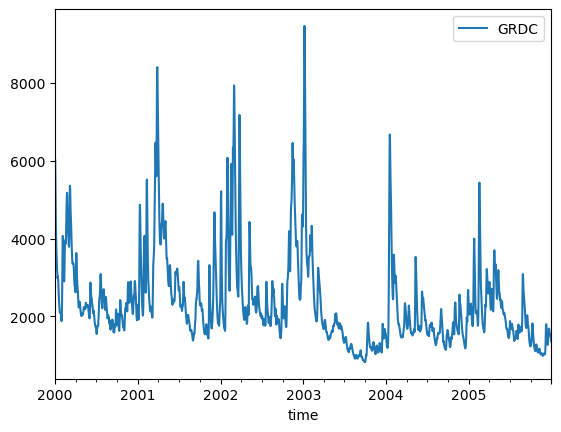

In [4]:
# Make a plot of the observation data. This allows to identify (long) periods of 
# missing data
observations.plot()

In [5]:
print(metadata)

{
    'grdc_file_name': '/mnt/data/observation/grdc/dailies/6335020_Q_Day.Cmd.txt',
    'id_from_grdc': 6335020,
    'file_generation_date': '2019-03-27',
    'river_name': 'RHINE RIVER',
    'station_name': 'REES',
    'country_code': 'DE',
    'grdc_latitude_in_arc_degree': 51.756918,
    'grdc_longitude_in_arc_degree': 6.395395,
    'grdc_catchment_area_in_km2': 159300.0,
    'altitude_masl': 8.0,
    'dataSetContent': 'MEAN DAILY DISCHARGE (Q)',
    'units': 'm³/s',
    'time_series': '1814-11 - 2016-12',
    'no_of_years': 203,
    'last_update': '2018-05-24',
    'nrMeasurements': 73841,
    'UserStartTime': '2000-01-01T00:00:00Z',
    'UserEndTime': '2005-12-31T00:00:00Z',
    'nrMissingData': 0
}

Forcing is created using the LumpedMakkinkForcing option in eWaterCycle. This selects rainfall and precipitation from the indicated dataset for the given time period and averages over the indicated shape. It calculates potential evaporation using the approximation by Makkink. The result is two NetCDF files and a yaml file. This can later be loaded using ```ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(forcingLocation)```. Depending on how busy the machine is and how big the area is  you are generating forcing for, the cell below can take minutes to run.

## Forcing from ERA5

In [6]:
#location to save forcing results
path = Path.cwd()
forcing_path = path / "Forcing"
saveLocationDirName = "GRDCStation" + grdc_station_id + "ERA5"
saveLocationERA5 = forcing_path / saveLocationDirName



In [7]:

#this line calls ESMValTool (throug ewatercycle) to generate the forcing

ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
    dataset="ERA5",
    start_time=observation_start_time,
    end_time=observation_end_time,
    shape=catchmentShapeFile.absolute(),
    directory=saveLocationERA5
)


In [8]:
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2000-01-01T00:00:00Z',
    end_time='2005-12-31T00:00:00Z',
    directory=PosixPath('/home/rhut/repos/ewatercycle-climatechangeimpact/Forcing/GRDCStation6335020ERA5/work/diagn
ostic/script'),
    shape=PosixPath('/home/rhut/repos/ewatercycle-climatechangeimpact/configFiles/Rhine.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2000-2005.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2000-2005.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2000-2005.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

## Forcing from Climate model (CMIP model)
We use the same code as above for ERA5, however, we now point to a different dataset. Note that for ERA5 we have a local copy downloaded on the machine where we are running, where as for CMIP data that is available through an ESGF node, ESMValTool will download the required files on the fly. Even if a shapefile is used for a cut-out of the earth, the intermediate files needed do cover the entire world. Since this download is locally cached, this can fill up your local hard disk quickly if a lot of data is required.

In [9]:
#location to save forcing results
path = Path.cwd()
forcing_path = path / "Forcing"
saveLocationDirName = "GRDCStation" + grdc_station_id + "CMIPHistorical"
saveLocationCMIPHistorical = forcing_path / saveLocationDirName



In [10]:
CMIP6_forcing_historical = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
    dataset=cmip_dataset_observation,
    start_time=observation_start_time,
    end_time=observation_end_time,
    shape=catchmentShapeFile.absolute(),
    directory=saveLocationCMIPHistorical
)


Let's make a view plots to look at the forcing just created. Forcing objects have the ```to_xarray()``` method and through that plots are easily made.

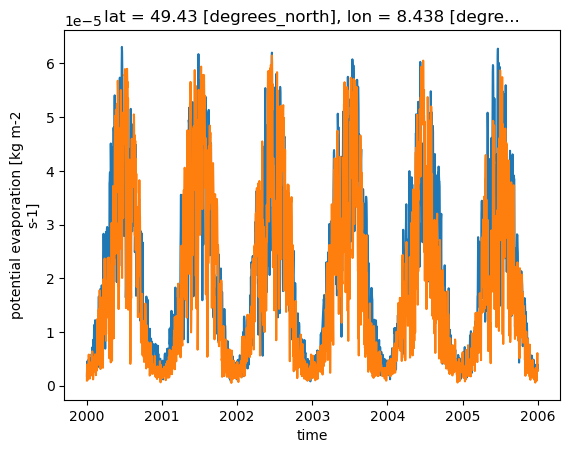

In [11]:
ERA5_forcing.to_xarray()["evspsblpot"].plot()
CMIP6_forcing_historical.to_xarray()["evspsblpot"].plot()

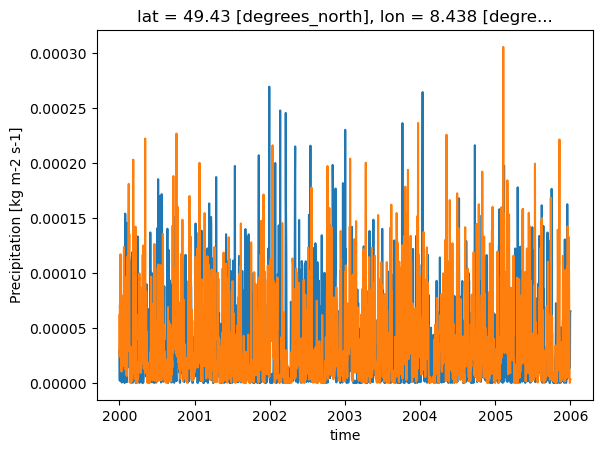

In [12]:
ERA5_forcing.to_xarray()["pr"].plot()
CMIP6_forcing_historical.to_xarray()["pr"].plot()

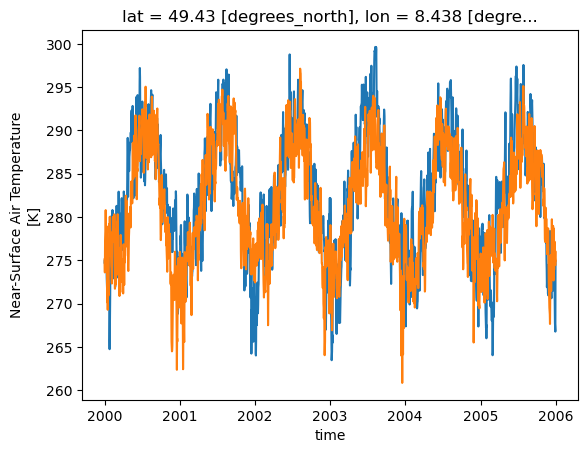

In [13]:
ERA5_forcing.to_xarray()["tas"].plot()
CMIP6_forcing_historical.to_xarray()["tas"].plot()